In [37]:
import os
import pandas as pd 
import numpy as np
import datetime as dt 
import math
import tensorflow as tf
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input, GRU, Dropout, Dense,LSTM, Attention,Bidirectional,MultiHeadAttention,Attention, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
import matplotlib.pyplot as plt 
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as xp
import plotly.subplots as sp
tf.test.gpu_device_name()
import yfinance as yf
goog = yf.Ticker("GOOG")
goog_df = goog.history(period="max")
goog_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,0.0,0.0
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,0.0,0.0
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,0.0,0.0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,0.0,0.0
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,0.0,0.0


In [38]:
goog_df.reset_index(inplace=True)

In [39]:
pred_open=goog_df[['Date','Open']]
pred_open

,Date,Open
0,2004-08-19 00:00:00-04:00,2.490664
1,2004-08-20 00:00:00-04:00,2.515820
2,2004-08-23 00:00:00-04:00,2.758411
3,2004-08-24 00:00:00-04:00,2.770615
4,2004-08-25 00:00:00-04:00,2.614201
...,...,...
4845,2023-11-16 00:00:00-05:00,136.960007
4846,2023-11-17 00:00:00-05:00,137.820007
4847,2023-11-20 00:00:00-05:00,135.500000
4848,2023-11-21 00:00:00-05:00,137.940002


In [40]:
goo=goog_df['Open']
goo

0         2.490664
1         2.515820
2         2.758411
3         2.770615
4         2.614201
           ...    
4845    136.960007
4846    137.820007
4847    135.500000
4848    137.940002
4849    139.100006
Name: Open, Length: 4850, dtype: float64

In [41]:

#Normalizing
scalar=MinMaxScaler(feature_range=(0,1))
goo=scalar.fit_transform(np.array(goo).reshape(-1,1))
goo.shape
#split train and test data
split_size=0.9
time_step=15
train,test=goo[0:int(len(goo)*split_size),:], goo[int(len(goo)*split_size):,:]
print(train.shape,test.shape)
#transform to time-series-like data
def time_series(goog_df,time_stemp):
    X=[]
    y=[]
    for i in range(len(goog_df)-time_step-1):
        a=goog_df[i:(i+time_stemp),0]
        X.append(a)
        y.append(goog_df[i+time_stemp])
    return np.array(X),np.array(y)
trainX,train_y=time_series(train,time_step)
testX,test_y=time_series(test,time_step)

print(trainX.shape,train_y.shape)
print(testX.shape,test_y.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
trainX =trainX.reshape(trainX.shape[0],trainX.shape[1] , 1)
testX = testX.reshape(testX.shape[0],testX.shape[1] , 1)

print("X_train: ", trainX.shape)
print("X_test: ", testX.shape)

(4365, 1) (485, 1)
(4349, 15) (4349, 1)
(469, 15) (469, 1)
X_train:  (4349, 15, 1)
X_test:  (469, 15, 1)


In [42]:
from attention import Attention
inputs=Input((time_step,1))
x=GRU(64,return_sequences=True)(inputs)
x=LSTM(32,return_sequences=True)(x)
x=Attention(32)(x)
x = Dense(32, activation="relu")(x)
x=Dropout(0.2)(x)
outputs=Dense(1)(x)
model=Model(inputs,outputs)   

optimizer=Adam(learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999)

model.compile(optimizer=optimizer,loss='mse')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 1)]           0         
                                                                 
 gru_2 (GRU)                 (None, 15, 64)            12864     
                                                                 
 lstm_2 (LSTM)               (None, 15, 32)            12416     
                                                                 
 attention_2 (Attention)     (None, 32)                3072      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33  

In [43]:
callbacks = [tensorflow.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
history=model.fit(trainX,train_y,
                  epochs=200,
                  validation_data=(testX,test_y),
                  verbose=1,
                  batch_size=32,
                  callbacks=callbacks
                 )

Epoch 1/200
136/136 [==============================] - 4s 14ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 2/200
136/136 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.0057
Epoch 3/200
136/136 [==============================] - 2s 11ms/step - loss: 0.0022 - val_loss: 0.0058
Epoch 4/200
136/136 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 5/200
136/136 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 6/200
136/136 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 7.4626e-04
Epoch 7/200
136/136 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0072
Epoch 8/200
136/136 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 9/200
136/136 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 6.7356e-04
Epoch 10/200
136/136 [==============================] - 1s 10ms/step - los

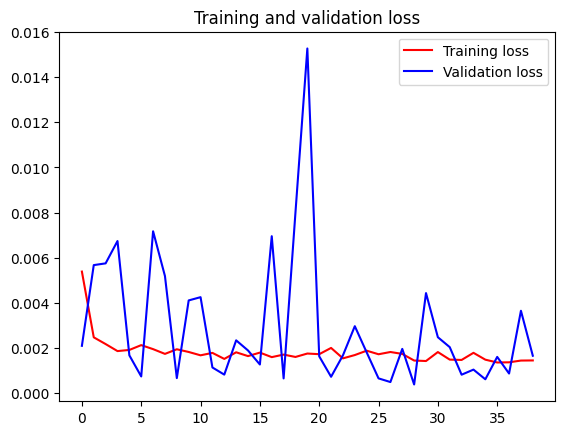

<Figure size 640x480 with 0 Axes>

In [44]:
#learning curves
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [45]:
train_predict=model.predict(trainX)
test_predict=model.predict(testX)
train_predict.shape, test_predict.shape

15/15 [==============================] - 0s 5ms/step


((4349, 1), (469, 1))

In [46]:
# Transform back to original form
train_predict = scalar.inverse_transform(train_predict)
test_predict = scalar.inverse_transform(test_predict)
original_ytrain = scalar.inverse_transform(train_y.reshape(-1,1)) 
original_ytest = scalar.inverse_transform(test_y.reshape(-1,1))

In [47]:
train_predict

array([[  3.6329124],
       [  3.6251476],
       [  3.6901617],
       ...,
       [144.60838  ],
       [142.28365  ],
       [142.65497  ]], dtype=float32)

In [48]:
test_predict

array([[136.43968 ],
       [138.95505 ],
       [140.48228 ],
       [140.08669 ],
       [136.99274 ],
       [137.03859 ],
       [137.06175 ],
       [136.44733 ],
       [133.77536 ],
       [128.9645  ],
       [131.48764 ],
       [132.02303 ],
       [131.98282 ],
       [130.74948 ],
       [133.98927 ],
       [135.78506 ],
       [144.96114 ],
       [138.16399 ],
       [138.83131 ],
       [139.68962 ],
       [136.27419 ],
       [138.56825 ],
       [137.1503  ],
       [137.09247 ],
       [133.45134 ],
       [137.4419  ],
       [135.8208  ],
       [136.03888 ],
       [133.85464 ],
       [132.11642 ],
       [133.07127 ],
       [127.81593 ],
       [134.76181 ],
       [132.6698  ],
       [133.71211 ],
       [133.50237 ],
       [134.46976 ],
       [132.27785 ],
       [131.69537 ],
       [127.56693 ],
       [132.14284 ],
       [130.9344  ],
       [132.87039 ],
       [129.88388 ],
       [128.5535  ],
       [131.35255 ],
       [132.4207  ],
       [132.4

In [49]:
look_back=time_step
trainPredictPlot = np.empty_like(goo)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

Train predicted data:  (4850, 1)


In [50]:
testPredictPlot = np.empty_like(goo)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(goo)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original open price','Train predicted open price','Test predicted open price'])

Test predicted data:  (4850, 1)


In [51]:
plotdf = pd.DataFrame({'Date': pred_open['Date'],
                       'original_open': pred_open['Open'],
                      'train_predicted_open': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_open': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = xp.line(plotdf,x=plotdf['Date'], y=[plotdf['original_open'],plotdf['train_predicted_open'],
                                          plotdf['test_predicted_open']],
              labels={'value':'Stock price','date': 'Date'})

fig.update_layout(title_text='Comparision between original open price vs predicted open price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Open Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [52]:
# calculate mse, mae and rmse between test predicted and test actual
mse = mean_squared_error(original_ytest, test_predict)
mae = mean_absolute_error(original_ytest, test_predict)
rmse = math.sqrt(mean_squared_error(original_ytest, test_predict))
print('Mean Squared Error: ', mse)
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)


Mean Squared Error:  8.730212715488777
Mean Absolute Error:  2.3123706907097463
Root Mean Squared Error:  2.9546933369621926
